<a href="https://colab.research.google.com/github/AdamPeetz/PlaneGAN/blob/main/ACGAN_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative adversarial networks: Auxiliary Classifier GANs  

 
 

  

  

 
 

Auxiliary Classifier Generative Adversarial Networks (ACGANs) are an extension of the Deep Convolutional GAN architecture that includes class prediction in the discriminator architecture. The addition of an auxiliary classifier teaches the GAN that the subject matter of the image is essential to the generation task. This focuses the model on producing the subject of the photo instead of plausible sets of background pixels. This has been shown to stabilize GAN training and improve the quality of images generated by the GAN. 

In [1]:
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn, random
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization, Dropout
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Concatenate
from keras.initializers import RandomNormal
from matplotlib import pyplot
import tensorflow as tf
import cv2
import numpy as np
import pathlib
from matplotlib import pyplot
import matplotlib as plt

import os, shutil 
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Model architecture: Defining a discriminator  

 
 

  

  

 
 

A discriminator network is used to predict whether an image is real or fake, and to which class that image belongs. Loss from the discriminator is used to train the generator to produce more convincing fake images over time.  

 
 

  

  

 
 

The discriminator takes an input that is the same size as the generator's output. The input tensor is down sampled through convolutional layers and flattened to make a prediction about whether that tensor is fake or real.   

 
 
 

In practice, ACGANs (Auxiliary Classifier GAN) can complete the auxiliary classification task by adding a second output to the end of the discriminator model that predicts the class of the image alongside the prediction of real or fake. This output layer uses activation and loss functions appropriate for multiclass classification tasks.  

  

 
 

Dropout is included in each layer of this discriminator to stabilize GAN training. A stride of 2 is used instead of pooling layers to reduce the size of the tensor in each layer. A kernel initializer is added to start the network weights with a normal distribution centered around 0. LeakyReLU is used as an activation function to prevent a vanishing gradient in the model.  

 

In [2]:
# define the standalone discriminator model
def define_discriminator(in_shape=(128,128,3), n_classes=10):
	# weight initialization
	init = RandomNormal(mean=0.0, stddev=0.02)
	# image input
	in_image = Input(shape=in_shape)
	# normal
	fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample 64x64
	fe = Conv2D(96, (3,3), strides=(2,2), kernel_initializer=init, padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.4)(fe)
	# downsample 32x32
	fe = Conv2D(128, (3,3), strides=(2,2), kernel_initializer=init, padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.4)(fe)
 	# downsample 16x16
	fe = Conv2D(192, (3,3), strides=(2,2), kernel_initializer=init, padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.4)(fe)
 	# downsample 8x8
	fe = Conv2D(256, (3,3), strides=(2,2), kernel_initializer=init, padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.4)(fe)
	# downsample 4x4
	fe = Conv2D(256, (3,3), strides=(2,2), kernel_initializer=init, padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Dropout(0.4)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# real/fake output
	out1 = Dense(1, activation='sigmoid',name='Real/Fake')(fe)
	# class label output
	out2 = Dense(n_classes, activation='softmax',name='ClassPrediction')(fe)
	# define model
	model = Model(in_image, [out1, out2])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

# Model architecture: Defining a generator  

 
 

  

  

 
 

A generator network is used to upscale noise into an image tensor.  

 
 

An ACGAN (Auxiliary Classifier GAN) has two inputs. One input takes a n-dimensional hypersphere and transposes that noise into a manifold of nodes. The second input takes in class labels and embeds those into a second n-dimensional manifold. These two inputs are concatenated and reshaped into a cluster of small tensors. These tensors are upscaled in successive layers to create larger tensors which are mapped into a 3-layer image tensor of the desired size.  

 
 

The generator uses Conv2DTranspose layers with a stride size of 2 to double the size of the tensor in each layer. Several best practices are employed to stabilize the generator during training. A filter size that is a factor of the stride size is used. A kernel initializer is employed to start the model with weights from a normal distribution centered around 0. LeakyReLU is used as an activation function to prevent vanishing gradients in the model except in the last layer which uses a tanh activation function. Dropout layers have been added to this model to test the effect of dropout in the generator. 

In [3]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# weight initialization
	init = RandomNormal(mean= 0.0, stddev=0.02)
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 4 * 4
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((4, 4, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 2048 * 4 * 4
	gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((4, 4, 2048))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 8x8
	gen = Conv2DTranspose(2048, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Dropout(0.4)(gen)
	# upsample to 16x16
	gen = Conv2DTranspose(1024, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Dropout(0.4)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(512, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Dropout(0.4)(gen)
	# upsample to 64x64
	gen = Conv2DTranspose(256, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Dropout(0.4)(gen)
	# upsample to 128x128
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), kernel_initializer=init, padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Dropout(0.4)(gen)
	# output
	out_layer = Conv2D(3, (3,3), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# Support equations: Defining the gan, loading images, generating samples  

 
 

  

  

 
 

## define_gan  

 
 

  

  

 
 

Combines the generator and discriminator into a single model. The weights on the discriminator are frozen in the combined model. This allows the loss during training to be back propagated through the generator only, improving its image generation over time.  

 
 

  

  

 
 

## load_custom_image_set  

 
 

  

  

 
 

Allows a custom dataset to be loaded for model training from a file directory location.   

 
 

  

  

 
 

## smooth_positive_labels  

 
 

  

  

 
 

Takes the positive hard label values of 1 and smooths them to a value between 0.7 and 1.2. This practice is recommended to stabilize GAN training.  

 
 

  

  

 
 

## generate_real_samples  

 
 

  

  

 
 

Creates a 4-dimensional tensor of real images from the dataset.   

 
 

  

  

 
 

## generate_latent_points  

 
 

  

  

 
 

Creates an array of points to use as input for the generator model. This array is drawn from a n-dimensional hypersphere.  

 
 

  

  

 
 

## generate_fake_samples  

 
 

  

  

 
 

Creates a 4-dimensional tensor of fake images from predictions made by the generator model.   

 
 

 

 

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
	# connect the outputs of the generator to the inputs of the discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and label and outputting real/fake and label outputs
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'sparse_categorical_crossentropy'], optimizer=opt)
	return model

# load custom image dataset, developed from tensorflow documentation
def load_custom_image_set(dataroot,resizedim,directorylevels):
    #image parse function
    def parse_image(filename):
        parts = tf.strings.split(filename, os.sep)
        label = parts[-2]
        label = int(label)
        image = tf.io.read_file(filename)
        image = tf.io.decode_jpeg(image)
        image = tf.image.convert_image_dtype(image, tf.float32)
        image = tf.image.resize(image, [resizedim,resizedim])
        image = (image * 2) -1
        return image, label
    
    data_root = pathlib.Path(dataroot)
    if directorylevels == 1:
      list_ds = tf.data.Dataset.list_files(str(data_root/'*/*'), shuffle=False)
    if directorylevels == 2:
      list_ds = tf.data.Dataset.list_files(str(data_root/'*/*/*'), shuffle=False)
    images_ds = list_ds.map(parse_image)
    #https://stackoverflow.com/questions/70535683/extract-data-from-tensorflow-dataset-e-g-to-numpy
    images = np.asarray(list(images_ds.map(lambda x, y: x)))
    labels = np.asarray(list(images_ds.map(lambda x, y: y)))
    return [images, labels]

# label smoothing function
def smooth_positive_labels(y):
	return y - 0.3 + (random(y.shape) * 0.5)

# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	# apply label smoothing
	y = smooth_positive_labels(y)
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator([z_input, labels_input])
	# convert output to numpy array
	images = images.numpy()
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# Support equations: Training metrics and output  

 
 

  

  

 
 

Model metrics are used to understand the performance of a GAN over time. A GAN will never converge on a solution and must be evaluated in other ways such as reviewing samples of images produced by the generator or monitoring the interaction of loss curves from the generator and discriminator.  

 
 
 

  

  

 
 

## summarize_performance  

 
 

  

  

 
 

Evaluates the model's ability to distinguish between fake and real images. Then saves a copy of the model and a sample of the images produced at that step in a file directory.  

 
 

  

  

 
 

## plot_history  

 
 

  

  

 
 

Creates a line plot of loss from the generator and discriminator.  

 
 

 

In [5]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, latent_dim, n_samples=100):
	# prepare fake examples
	[X, _], _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i])
	# save plot to file
	filename1 = '/content/gdrive/My Drive/planegan/sample_output/generated_plot_e%03d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# save the generator model
	filename2 = '/content/gdrive/My Drive/planegan/saved_models/generator_model_%03d.h5' % (step+1)
	g_model.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))
 
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
	# plot loss
		pyplot.subplot(2, 1, 1)
		pyplot.plot(d1_hist, label='d-real')
		pyplot.plot(d2_hist, label='d-fake')
		pyplot.plot(g_hist, label='gen')
		pyplot.legend()
	# plot discriminator accuracy
		pyplot.subplot(2, 1, 2)
		pyplot.plot(a1_hist, label='acc-real')
		pyplot.plot(a2_hist, label='acc-fake')
		pyplot.legend()
	# save plot to file
		pyplot.savefig('/content/gdrive/My Drive/planegan/saved_models/plot_line_plot_loss.png')
		pyplot.close()
	


# Training a GAN: Custom training loop  

 
 

  

  

 
 

GAN training requires a custom training loop.   

 
 

  

  

 
 

First the training loop uses a half batch of real or fake images to independently train the discriminator to predict if an image is real or fake. It then trains the combined GAN on a batch of fake images and uses the loss to train the weights in the generator only. This process trains the generator to produce more realistic images over time.  

 
 

  

  

 
 

The summarize performance function is added to the end of the training loop to record metrics at certain points during the training run. 

 

In [6]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=300, n_batch=128):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# get randomly selected 'real' samples
		[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
		# update discriminator model weights
		_,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])
		# generate 'fake' examples
		[X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model weights
		_,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
		# prepare points in latent space as input for the generator
		[z_input, z_labels] = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		_,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
		# summarize loss on this batch
		print('>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]' % (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
		# evaluate the model performance every 'epoch'
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, latent_dim)

# Loading Training Data  

 
 

  

  

 
 

Load training data from a file directory with multiple levels. This supports file directories where images have been divided based on classes (directorylevels=1) or further segmented into training and test sets inside those class folders (directorylevels=2). It also allows input images to be resized to the required dimensions for the GAN.  

 
 

 

In [7]:
# load image data
image_path = "/content/gdrive/My Drive/planegan/airplanes_resized/"
resizedim = 128
directorylevels = 1
dataset = load_custom_image_set(image_path,resizedim,directorylevels)

# EDA: Displaying image samples 

 
 

GANs should be evaluated based on their ability to produce images that are like the training dataset. This section of code displays a random sample of images from the training dataset. 

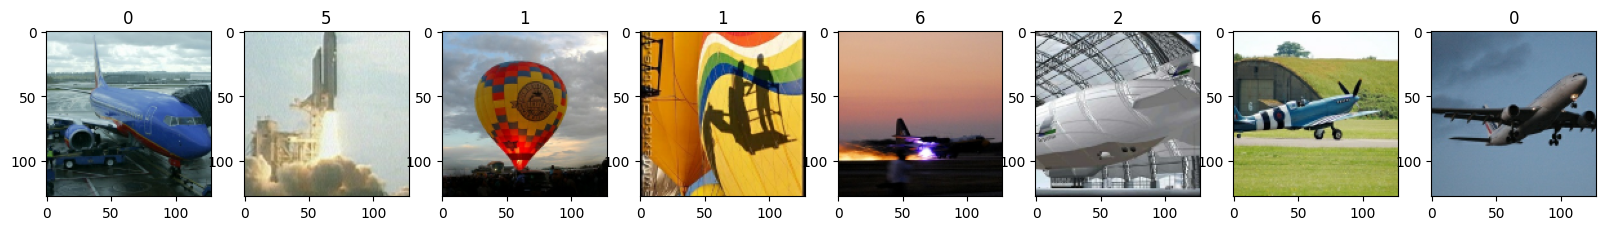

In [8]:
# Setup the subplot formatting 
fig, ax = pyplot.subplots(ncols=8, figsize=(20,20))
# Loop four times and get images 
for idx in range(8): 
    index = randint(0, len(dataset[0]))
    # Grab an image and label
    image = (dataset[0][index] + 1) / 2.0
    label = dataset[1][index]
    # Plot the image using a specific subplot 
    ax[idx].imshow(image)
    # Appending the image label as the plot title 
    ax[idx].title.set_text(label)

# Creating a GAN: Combining a discriminator and a generator 

 
 

Define the generator and discriminator models using the functions created above, then wrap these models into a GAN. The number of latent dimensions used for input is also defined, and the parameters of the generator are summarized. 

In [9]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
generator.summary()
# create the gan
gan_model = define_gan(generator, discriminator)


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 32768)        3309568     ['input_3[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_2[0][0]']                
                                                                                            

# Training the model

Engage the custom training loop by calling it with the parameters defined above.

In [ ]:
# train model
train(generator, discriminator, gan_model,  dataset,  latent_dim, n_epochs=600,)


# References

Abadi, A., Agarwal, P. B., Brevdo, E., Chen, Z., Citro, C., Corrado, G., Davis, A., Dean, J., Devin, M., Ghemawat, S., Goodfellow, I.,Harp, A., Irving, G., Isard, M., Jozefowicz, R., Jia Y., Kaiser, L., Kudlur, M., Levenberg, J., Mané, D., Schuster, M., Monga, R., Moore, S. Murray, D., Olah, C., Shlens, J., Steiner, B., Sutskever, I., Talwar, K., Tucker, P., Vanhoucke, V., Vasudevan, V., Viégas, F., Vinyals, O., Warden, P., Wattenberg, M., Wicke, M., Yu, Y., & Zheng. X., (2015). TensorFlow: Largescale machine learning on heterogeneous systems. Software available from tensorflow.org ​

Boe, Bryce. (2023). PRAW: The Python Reddit API Wrapper. Reddit.com​

Brownlee, Jason. (2019). Generative Adversarial Networks with Python. Machine Learning Mastery. EBook. ​

Chintala, Soumith. Denton, Emily. Arjovsky, Martin. Mathieu, Michael. (2023). How to Train a GAN? Tips and tciks to make GANs work. Githib. Retreived 4/2/2023 from guthub.com/soumith/ganhacks​

Chollet, Francois. (2015). Keras. GitHub. https://github.com/fchollet/keras  ​

Das Shuvo, Falguni. (2020). Repeatedly calling model.predict(...) results in memory leak. GitHub. Retrieved 3/15/2023 from https://github.com/keras-team/keras/issues/13118 https://machinelearningmastery.com/generative_adversarial_networks/​

Deng, Jia., Dong, Wei., Socher, Richard., Li, Li-Jia., Li, Kia., Fei-Fei, Li. (2009). ImageNet: A large-scale hierarchical image database. IEEE Conference on Computer Vision and Pattern Recognition.   pp. 248-255, doi: 10.1109/CVPR.2009.5206848.​

Harris, C.R., Millman, K.J., van der Walt, S.J. et al. (2020) Array programming with NumPy. Nature 585, 357–362. DOI: 10.1038/s41586-020-2649-2 ​

Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering. https://zenodo.org/badge/DOI/10.5281/zenodo.592536.svg ​

Karras, Tero. Aila, Timo. Laine, Samuli. Lehtinen, Jaakko. (2017). Progressive Growing of GANs for Improved Quality, Stability, and Variation. arXiv:1710.10196 ​

Krizhevsky, Alex. Sutskever, Ilya. & Hinton, Geoffrey. (2017). ImageNet classification with deep convolutional neural networks. Communications of the ACM. 60(8). DOI: 10.1145/3065386​

Lower, Jacob. (2022). RedditImageScraper. retrieved 01/13/2023 from https://github.com/ClarityCoders/RedditImageScraper​

OpenCV Team. (2023). ComputerVision2 (cv2). Opencv.org ​

Regis Jesuit University. (2021). MSDS600 Intro to Data Science . Regis University​

Regis Jesuit University. (2022). MSDS660 Deep Learning. Regis University​

Renotte, Nicholas. (2022). GANBasics. Github.com. Retrieved 04/01/2023 from  githuib.com/nicknochnack/GANBasics​

r/helicopters. (2023). Image dataset. Reddit.com. Retrieved 03/26/2023​

r/warplaneporn. (2023). Image dataset. Reddit.com. Retrieved 03/26/2023